In [1]:
!pip install nltk
!pip install torch

In [3]:
import random
import os

# Initial Corpus Dataset (randomization)

dictionary = [
    ['dog', 'cat', 'animal', 'goldfish', 'pet', 'house', 'sleep', 'play'],
    ['lion', 'zebra', 'mammal', 'africa', 'elephant', 'cheetah', 'hunt', 'animal'],
    ['crown', 'queen', 'king', 'kingdom', 'peasant', 'royal', 'country', 'rule', 'castle']
]
text_corpus = ""
file_location = "Datasets/text_corpus.txt"
iteration_count = 10000

def shuffle_corpus(pos):
    random.shuffle(dictionary[pos])
    return ' ' + ' '.join(dictionary[pos])

def generate_corpus(iterations, pos):
    global text_corpus
    for a in range(iterations):
        add_string = shuffle_corpus(pos)
        text_corpus += add_string

for i in range(len(dictionary)):
    generate_corpus(iteration_count, i)

if os.path.exists(file_location):
    os.remove(file_location) 

with open(file_location, 'w') as file:
    file.write(text_corpus)

print("Text Corpus Uploaded")

Text Corpus Uploaded


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer

nltk.download('stopwords')

file_location = "Datasets/text_corpus.txt"
text_corpus = ""
with open(file_location, 'r') as file:
    text_corpus = file.read()
    
# Text Normalization + Tokenization
def generate_cbows(text, window_size):
    text = text.lower()
    words = TreebankWordTokenizer().tokenize(text)
    words = [word for word in words if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    cbows = []
    for i, target_word in enumerate(words):
        context_words = words[max(0, i - window_size):i] + words[i + 1:i + window_size + 1]
        if len(context_words) == window_size * 2:
            cbows.append((context_words, target_word))
    return cbows

cbows = generate_cbows(text_corpus, window_size=3)

for context_words, target_word in cbows[:5]:
    print(f'Context Words: {context_words}, Target Word: {target_word}'  )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Context Words: ['pet', 'cat', 'play', 'house', 'animal', 'goldfish'], Target Word: dog
Context Words: ['cat', 'play', 'dog', 'animal', 'goldfish', 'sleep'], Target Word: house
Context Words: ['play', 'dog', 'house', 'goldfish', 'sleep', 'animal'], Target Word: animal
Context Words: ['dog', 'house', 'animal', 'sleep', 'animal', 'sleep'], Target Word: goldfish
Context Words: ['house', 'animal', 'goldfish', 'animal', 'sleep', 'house'], Target Word: sleep


In [5]:
import torch

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer

def find_unique_words(file_location):
    text_corpus = ""
    with open(file_location, 'r') as file:
        text_corpus = file.read()
    text_corpus = text_corpus.lower()
    words = TreebankWordTokenizer().tokenize(text_corpus)
    words = [word for word in words if word.isalpha()]
    return sorted(set(words))
    
unique_words = find_unique_words("Datasets/text_corpus.txt")

# Converting context words and target word into one-hot encodings, then into torch tensors.

def one_hot_encoding(word, unique_words):
    encoding = [1 if word == i else 0 for i in unique_words]
    return torch.tensor(encoding, dtype=torch.float32)
    
encodings = {word: one_hot_encoding(word, unique_words) for word in unique_words}

cbow_vector_pairs = [([encodings[context_word] for context_word in context_words], encodings[target_word]) for context_words, target_word in cbows]
cbow_vector_pairs = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector) for context_vectors, target_vector in cbow_vector_pairs]
print(cbow_vector_pairs[:1])

[(tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0.]), tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]))]


In [4]:
import torch
import random
from torch.utils.data import Dataset, DataLoader

class WordDataset(Dataset):
    def __init__(self, tensors, transform=None):
        self.inputs = [tensor[0] for tensor in tensors]
        self.outputs = [tensor[1] for tensor in tensors]
        self.transform = transform
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
    
    def __len__(self):
        return len(self.inputs)
    
random.shuffle(cbow_vector_pairs)
split_index = int(len(cbow_vector_pairs) * .9)

train_dataset = WordDataset(cbow_vector_pairs[split_index:])
test_dataset = WordDataset(cbow_vector_pairs[:split_index] )
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Data Loaded.")

Data Loaded.


In [11]:
import os
import torch
from torch import nn

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class NaiveWord2Vec(nn.Module):
    def __init__(self, VOCAB_SIZE, VECTOR_DIM) -> None:
        super().__init__()
        self.vocab_size = VOCAB_SIZE
        self.vector_dim = VECTOR_DIM
        self.W1 = nn.Parameter(data=torch.randn(self.vocab_size, self.vector_dim), requires_grad=True)
        self.W2 = nn.Parameter(data=torch.randn(self.vector_dim, self.vocab_size), requires_grad=True)
        
    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = X @ self.W2
        return X
    
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 2

model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM)

def train_model(model, train_dataloader, test_dataloader, epochs, learning_rate, verbose=False):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
    
    train_set_loss_log = []
    validation_set_loss_log = []
    
    for epoch in range(epochs):
        
        if verbose: print('Epoch: ' + str(epoch))
            
        model.train()
        total_train_loss = 0.0
        num_train_batches = 0
        
        for input_batch, output_batch in train_dataloader:
            train_logits = model(input_batch)
            train_loss = loss_fn(train_logits, output_batch)
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            total_train_loss += train_loss.item()
            num_train_batches += 1
        
        average_train_loss = total_train_loss / num_train_batches
        train_set_loss_log.append(average_train_loss)
        
        model.eval()
        total_validation_loss = 0.0
        num_validation_batches = 0
        
        with torch.inference_mode():
            for input_batch, output_batch in test_dataloader:
                val_logits = model(input_batch)
                val_loss = loss_fn(val_logits, output_batch)
                
                total_validation_loss += val_loss.item()
                num_validation_batches += 1
                
        average_validation_loss = total_validation_loss / num_validation_batches
        validation_set_loss_log.append(average_validation_loss) 
        
        if verbose: print("Train Loss: ", average_train_loss, "|||", "Validation Loss: ", average_validation_loss)

    return model, train_set_loss_log, validation_set_loss_log
            
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_dataloader, test_dataloader, epochs=10, learning_rate=.01, verbose=True)


Using cpu device
Epoch: 0
Train Loss:  2.7726370611459092 ||| Validation Loss:  2.116925833880291
Epoch: 1
Train Loss:  2.0915605671265545 ||| Validation Loss:  2.079321177881868
Epoch: 2
Train Loss:  2.077547168487783 ||| Validation Loss:  2.07423402302908
Epoch: 3
Train Loss:  2.0741955901655698 ||| Validation Loss:  2.0735276527575666
Epoch: 4
Train Loss:  2.070113880250155 ||| Validation Loss:  2.076956768559379
Epoch: 5
Train Loss:  2.0693071656824684 ||| Validation Loss:  2.0744971709921365
Epoch: 6
Train Loss:  2.0694124534002047 ||| Validation Loss:  2.074785241427004
Epoch: 7
Train Loss:  2.066324754749113 ||| Validation Loss:  2.068360312806868
Epoch: 8
Train Loss:  2.0655256119530523 ||| Validation Loss:  2.0665789988396246
Epoch: 9
Train Loss:  2.065265933266076 ||| Validation Loss:  2.0672155797684963


In [13]:
parameters = list(model.parameters())
word_vectors = parameters[0].detach()
word_dictionary = {word: vector for word, vector in zip(unique_words, word_vectors)}
print(word_dictionary)

{'africa': tensor([-0.1108, -0.7904]), 'animal': tensor([-0.4560,  0.8001]), 'castle': tensor([0.2781, 0.0976]), 'cat': tensor([ 1.2299, -0.5213]), 'cheetah': tensor([-0.1384, -2.2593]), 'country': tensor([-0.5909,  0.9916]), 'crown': tensor([0.3561, 0.3729]), 'dog': tensor([1.3834, 0.1118]), 'elephant': tensor([-0.5861, -1.3387]), 'goldfish': tensor([ 1.4978, -0.3157]), 'house': tensor([ 0.7223, -0.4670]), 'hunt': tensor([-0.3729, -0.7638]), 'king': tensor([-0.1143,  0.7030]), 'kingdom': tensor([-0.9297,  0.7860]), 'lion': tensor([-0.0607, -0.7938]), 'mammal': tensor([-0.0141, -0.7620]), 'peasant': tensor([0.8523, 3.0673]), 'pet': tensor([0.8130, 0.0199]), 'play': tensor([ 0.9937, -0.4754]), 'queen': tensor([-1.0422,  0.9143]), 'royal': tensor([-0.2658,  0.1574]), 'rule': tensor([0.1139, 0.2867]), 'sleep': tensor([ 1.6559, -0.2819]), 'zebra': tensor([-0.3422, -0.4741])}


In [25]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))

def find_top_k_similar(target, word_dict, top_k):
    distance_log = {}
    for word, tensor in word_dict.items():
        if word != target:
            distance_log[word] = cosine_similarity(tensor, word_dict[target])
    distance_log = sorted(distance_log.items(), key=lambda x: x[1], reverse=True)
    return distance_log[:top_k]

print(find_top_k_similar('dog', word_dictionary, 5))

[('pet', tensor(0.9984)), ('sleep', tensor(0.9691)), ('castle', tensor(0.9672)), ('goldfish', tensor(0.9587)), ('cat', tensor(0.8863))]


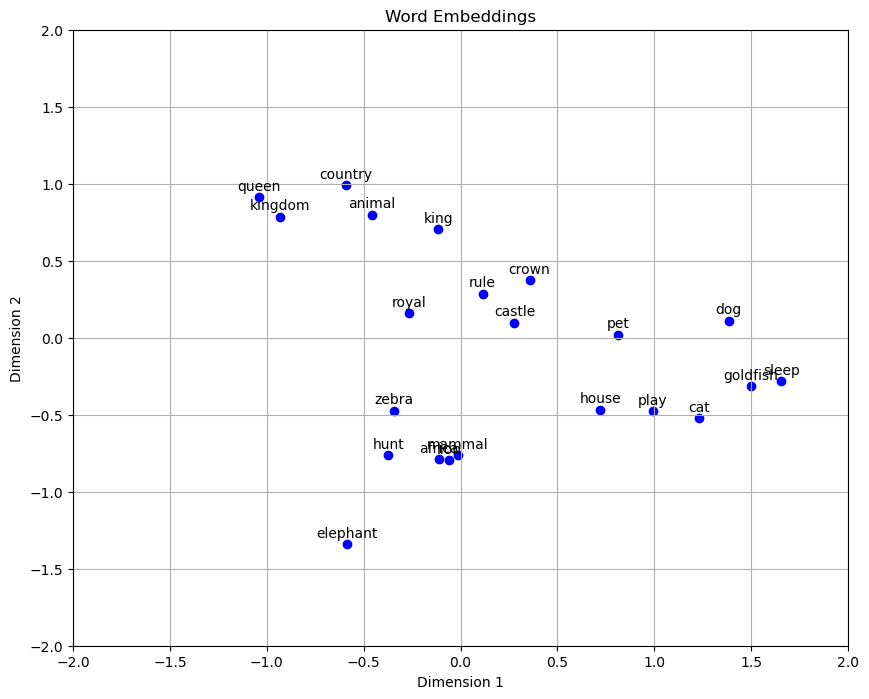

In [31]:
import matplotlib.pyplot as plt

x_cords, y_cords = zip(*[word_dictionary[word].numpy() for word in list(word_dictionary.keys())])

plt.figure(figsize=(10, 8))
plt.scatter(x_cords, y_cords, marker='o', color='blue')

for i, word in enumerate(list(word_dictionary.keys())):
    plt.annotate(word, (x_cords[i], y_cords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()